In [11]:
import os
from pathlib import Path
import pickle
import numpy as np
from tqdm import tqdm
import skimage.measure
from skimage.morphology import dilation, erosion
from sklearn.mixture import GaussianMixture
from skimage.measure import label
from PIL import Image
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact
from ipywidgets import interactive
from warnings import filterwarnings
filterwarnings('ignore')

In [ ]:
"""
Training GMM w/ background data
"""

downsampleSize = 2
skipAmount = 4
nComponents = 5
folderList = ['dataset/Crowd_PETS09/S0/Background/View_001/Time_13-06',
              'dataset/Crowd_PETS09/S0/Background/View_001/Time_13-32']

# ref = Image.open(folderList[0] + '/' + os.listdir(folderList[0])[0])
trainingData = [] # np.zeros(np.array(ref.convert('L')).shape)

for folder in folderList:
    for i, file in enumerate(os.listdir(folder)):
        if i % skipAmount == 0:
            img = Image.open(folder + '/' + file)
            img = np.array(img.convert('L')) # grayscale
            img = skimage.measure.block_reduce(img, downsampleSize, np.mean) # downsample
            trainingData.append(img)
trainingData = np.array(trainingData)

# N = np.arange(1, 6)
mixtureModels = []
for i in tqdm(range(trainingData.shape[1])):
    temp = []
    for j in range(trainingData.shape[2]):
        pixelValues = trainingData[:, i, j]
        # models = [None for j in range(len(N))]

        # for k in range(len(N)):
        #     models[k] = GaussianMixture(n_components=N[k]).fit(pixelValues.reshape(-1, 1))
        # AIC = [m.aic(pixelValues.reshape(-1, 1)) for m in models]
        # temp.append(models[np.argmin(AIC)])
        temp.append(GaussianMixture(n_components=nComponents).fit(pixelValues.reshape(-1, 1)))
    mixtureModels.append(temp)

with open('methods/baseline-indirect/GMM.pkl', 'wb') as f:
    pickle.dump(mixtureModels, f)

1it [00:25, 25.20s/it]

Pixels under threshold: 4806
Number of people: 8


2it [00:49, 24.58s/it]

Pixels under threshold: 5766
Number of people: 9


3it [01:13, 24.54s/it]

Pixels under threshold: 6217
Number of people: 10


4it [01:37, 24.30s/it]

Pixels under threshold: 6362
Number of people: 11


5it [02:02, 24.52s/it]

Pixels under threshold: 6625
Number of people: 9


6it [02:26, 24.43s/it]

Pixels under threshold: 6775
Number of people: 12


7it [02:51, 24.37s/it]

Pixels under threshold: 7005
Number of people: 13
Pixels under threshold: 7494


8it [03:15, 24.36s/it]

Number of people: 12


9it [03:41, 24.79s/it]

Pixels under threshold: 8259
Number of people: 9
Pixels under threshold: 8417


10it [04:05, 24.76s/it]

Number of people: 10
Pixels under threshold: 8576


11it [04:30, 24.75s/it]

Number of people: 11
Pixels under threshold: 8385


12it [04:56, 24.95s/it]

Number of people: 12
Pixels under threshold: 8309


13it [05:21, 25.10s/it]

Number of people: 10
Pixels under threshold: 8385


14it [05:47, 25.39s/it]

Number of people: 12
Pixels under threshold: 8434


15it [06:13, 25.46s/it]

Number of people: 10
Pixels under threshold: 8832


16it [06:39, 25.62s/it]

Number of people: 14
Pixels under threshold: 8797


17it [07:04, 25.63s/it]

Number of people: 13
Pixels under threshold: 10024


18it [07:30, 25.78s/it]

Number of people: 17
Pixels under threshold: 10109


19it [07:56, 25.56s/it]

Number of people: 12
Pixels under threshold: 10311


20it [08:22, 25.95s/it]

Number of people: 19
Pixels under threshold: 10684


21it [08:46, 25.31s/it]

Number of people: 18
Pixels under threshold: 10722


22it [09:10, 24.83s/it]

Number of people: 21
Pixels under threshold: 10873


23it [09:34, 24.53s/it]

Number of people: 22
Pixels under threshold: 11718


24it [09:57, 24.28s/it]

Number of people: 20
Pixels under threshold: 11962


25it [10:21, 24.15s/it]

Number of people: 23
Pixels under threshold: 12252


26it [10:45, 24.01s/it]

Number of people: 25
Pixels under threshold: 11900


27it [11:09, 24.00s/it]

Number of people: 24
Pixels under threshold: 12260


28it [11:33, 23.99s/it]

Number of people: 23
Pixels under threshold: 12807


29it [11:57, 23.94s/it]

Number of people: 23
Pixels under threshold: 13639


84it [12:21,  1.01it/s]

Number of people: 25


222it [12:21,  3.34s/it]


[8, 9, 10, 11, 9, 12, 13, 12, 9, 10, 11, 12, 10, 12, 10, 14, 13, 17, 12, 19, 18, 21, 22, 20, 23, 25, 24, 23, 23, 25]


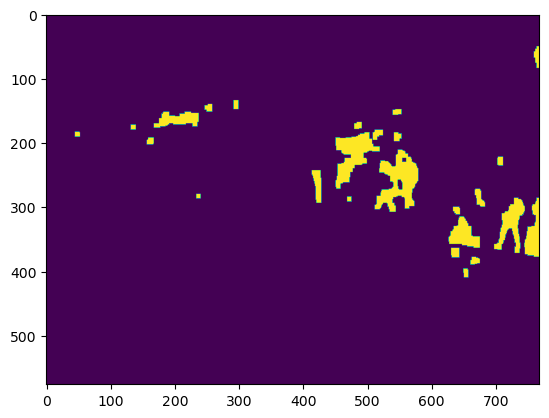

In [12]:
"""
Eval
"""
with open('methods/baseline-indirect/GMM.pkl', 'rb') as f:
    mixtureModels = pickle.load(f)

directory = 'dataset/Crowd_PETS09/S0/Regular_Flow/Time_13-57/View_001'
result = []
for num, filename in tqdm(enumerate(os.listdir(directory))):
    f = os.path.join(directory, filename)
    if os.path.isfile(f):
        if num < 30:
            img = Image.open(f)
            img = np.array(img.convert('L')) # grayscale
            output = np.zeros(img.shape)
            for i in range(img.shape[0]):
                for j in range(img.shape[1]):
                    model = mixtureModels[int(i / 2)][int(j / 2)]
                    output[i, j] = model.score_samples(img[i, j].reshape(-1, 1))[0]
            
            thresh = -250
            view = np.copy(output)
            print(f'Pixels under threshold: {np.sum(output < thresh)}')
            t1 = np.where(view < thresh)
            t2 = np.where(view >= thresh)
            view[t1] = 255
            view[t2] = 0

            # plt.imshow(view)
            # plt.show()

            k = 5
            view = dilation(view, footprint=np.ones((k, k)))
            view = erosion(view, footprint=np.ones((k, k)))

            k = 7
            view = erosion(view, footprint=np.ones((k, k)))
            view = dilation(view, footprint=np.ones((k, k)))

            plt.imshow(view)
            plt.savefig(directory + '/output/' + Path(f).stem + '_eval.png')
            # plt.show()

            countComponents = label(view)
            print(f'Number of people: {np.max(countComponents)}')
            result.append(np.max(countComponents))

with open('methods/baseline-indirect/result.pkl', 'wb') as f:
    pickle.dump(result, f)

print(result)

In [15]:
label = [6, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10,
         11, 12, 12, 13, 13, 13, 13, 14, 14, 14, 15, 15] # ground truth for frame 0000-0029
print(len(label))
print(f'MSE: {np.sum(np.square(np.array(result) - np.array(label))) / len(label)}')
print(f'Average Error: {np.sum(np.abs(np.array(result) - np.array(label))) / len(label)}')

30
MSE: 33.266666666666666
Average Error: 4.666666666666667


In [3]:
"""
Visualization
"""
@widgets.interact(thresh=(-500, 0))
def plot_bin_val_distribution(thresh):
    print(f'Pixels under threshold: {np.sum(output < thresh)}')

    view = np.copy(output)
    t1 = np.where(view < thresh)
    t2 = np.where(view >= thresh)
    view[t1] = 255
    view[t2] = 0

    plt.imshow(img)
    plt.colorbar()
    plt.show()

    plt.imshow(view)
    plt.show()

    k = 5
    view = dilation(view, footprint=np.ones((k, k)))
    view = erosion(view, footprint=np.ones((k, k)))

    k = 7
    view = erosion(view, footprint=np.ones((k, k)))
    view = dilation(view, footprint=np.ones((k, k)))

    plt.imshow(view)
    plt.show()

    countComponents = label(view)
    print(f'Number of people: {np.max(countComponents)}')

interactive(children=(IntSlider(value=-250, description='thresh', max=0, min=-500), Output()), _dom_classes=('…

TODO: 
1) try adding mask on unimportant zones
2) do a search over threshold value and noise removal parameters
3) try cleaning result with gaussian blur from hw3
4) visualize good sample (pixel) of GMM distribution for presentations